# Notebook to showcase the basic functioning of the wfc3_dash module

Table of Contents: <br>
1. <a href='#imports'>Imports</a>
2. <a href='#introduction'>Introduction</a>
3. <a href='#downloads'>Downloading Relevant Data </a>
4. <a href='#DASH'>Running DASH </a> <br>
    a) <a href='#object'> Creating DashData object <br> </a>
    b) <a href='#diff_files'> Create diff files <br> </a>
    c) <a href='#asn_table'> Create association tables <br> </a>
    d) <a href='#subtract_flt'> Subtract background from original FLT <br> </a>
    e) <a href='#subtract_ext'> Subtract background from new FLT's <br> </a>
    f) <a href='#cosmic_rays'> Fix cosmic rays <br> </a>
    g) <a href='#align_each_other'> Align reads to each other <br> </a>
    h) <a href='#align_cat'> Align reads to catalog <br> </a>
    i) <a href='#align_both'> Align reads to each other, then to gaia catalog <br> </a>
5. <a href='#mosaic'> Creating Mosaic </a>

<a id='imports'></a>

## Imports

* *astroquery.mast Observations* used to download IMA files from the MAST HST archive
* *astropy.io import fits* used to open the files
* *matplotlib.pyplot* used to plot the images
* *numpy* used for some math

In [1]:
from astroquery.mast import Observations
from astropy.io import fits 
from astropy.table import Table
import matplotlib.pyplot as plt 
import numpy as np

%matplotlib notebook 

<a id='introduction'></a>

## Introduction

The wfc3_dash submodule of wfc3_tools is used to reduce the effects of the spacecraft drift for WFC3/IR images taken in DASH mode (i.e. under GYRO control, rather than under Fine-Guide-Sensor control)

This notebook works on a single .flt file but can be easily adapted to work on all exposures within a DASH visit or even a DASH program

<a id='downloads'></a>

## Downloading some relevant data

#### Get the table of observations associated to GO-14114 (PI van Dokkum, the first proposal to use the DASH mode)

In [2]:
obsTable = Observations.query_criteria(proposal_id=['14114'])

#### Get the full list of products associated to the table and restrict the list to IMA files

In [3]:
product_list = Observations.get_product_list(obsTable)
BM = (product_list['productSubGroupDescription']  == 'IMA') 
product_list = product_list[BM]

#### Display (part of) the IMA files list

In [4]:
product_list.show_in_notebook(display_length=5)

#### Pick a single exposure file to work on

In [5]:
myID = product_list['obsID'][0:1]

#### Download the IMA and FLT files for that exposure. The standard pipeline-FLT will be used for comparison with the detrended final product

In [6]:
download = Observations.download_products(myID,mrp_only=False,productSubGroupDescription=['IMA','FLT'])

INFO: Found cached file ./mastDownload/HST/icxe01tyq/icxe01tyq_ima.fits with expected size 126201600. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/icxe01tyq/icxe01tyq_flt.fits with expected size 16591680. [astroquery.query]


#### Display the results of the download operation

In [7]:
download

<Table length=2>
                   Local Path                    Status  Message  URL  
                     str47                        str8    object object
----------------------------------------------- -------- ------- ------
./mastDownload/HST/icxe01tyq/icxe01tyq_ima.fits COMPLETE    None   None
./mastDownload/HST/icxe01tyq/icxe01tyq_flt.fits COMPLETE    None   None

#### Read the files that were just downloaded locally 

In [8]:
#have path be everything minus last 8 characters (ima.fits)
localpathtofile = download['Local Path'][0][:-8]
localpathtofile

original_ima = fits.open(localpathtofile+'ima.fits')
original_flt = fits.open(localpathtofile+'flt.fits')
original_ima.info()

Filename: ./mastDownload/HST/icxe01tyq/icxe01tyq_ima.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     260   ()      
  1  SCI           1 ImageHDU        81   (1024, 1024)   float32   
  2  ERR           1 ImageHDU        43   (1024, 1024)   float32   
  3  DQ            1 ImageHDU        35   (1024, 1024)   int16   
  4  SAMP          1 ImageHDU        30   ()      
  5  TIME          1 ImageHDU        30   ()      
  6  SCI           2 ImageHDU        81   (1024, 1024)   float32   
  7  ERR           2 ImageHDU        43   (1024, 1024)   float32   
  8  DQ            2 ImageHDU        35   (1024, 1024)   int16   
  9  SAMP          2 ImageHDU        30   ()      
 10  TIME          2 ImageHDU        30   ()      
 11  SCI           3 ImageHDU        81   (1024, 1024)   float32   
 12  ERR           3 ImageHDU        43   (1024, 1024)   float32   
 13  DQ            3 ImageHDU        35   (1024, 1024)   int16   
 14  SAMP          

#### Plot the individual reads of the IMA file
Note: the individual 'SCI' extensions are stored in reverse order, with 'SCI', 1 corresponding to the last read

NSAMP 12


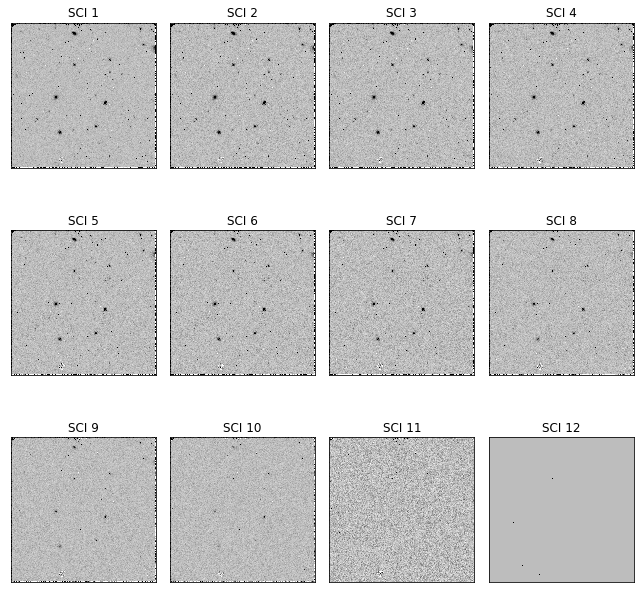

In [9]:
nsamp = original_ima[0].header['NSAMP']
print('NSAMP',nsamp)
fig,axarr = plt.subplots((nsamp+3)//4,4, figsize=(9,3*((nsamp+3)//4)))

for i in range(1,4*((nsamp+3)//4)+1):

    row = (i-1)//4
    col = (i-1)%4
    if (i <= nsamp):
        immed = np.nanmedian(original_ima['SCI',i].data)
        stdev = np.nanstd(original_ima['SCI',i].data)
        axarr[row,col].imshow(original_ima['SCI',i].data,clim=[immed-.3*stdev,immed+.5*stdev],cmap='Greys',origin='lower')
        axarr[row,col].set_title('SCI '+str(i))
        axarr[row,col].set_xticks([]) 
        axarr[row,col].set_yticks([]) 
    else:
        fig.delaxes(axarr[row,col])

fig.tight_layout()

<a id='DASH'></a>

## Run the individual steps of the DASH pipeline

Run the DASH pipeline for a single exposure.  
This procedure showcases the capabilities and customization options of the DASH pipeline.

#### This cell is inserted temporarily to allow for relative imports until the whole wfc3_dash submodule is properly packaged and installed within the wfc3_tools module

In [10]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from reduce_dash import DashData

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


<a id='object'></a>

### 1. Create a DashData object using the path to the ima file we have downloaded above

In [11]:
myDash = DashData(localpathtofile+'ima.fits', flt_file_name=localpathtofile+'flt.fits')

<a id='diff_files'></a>

### 2. Create diff files

A diff file contains the counts accumulated between two reads.  
The diff files are written to disk in a directory named ./diff under the current working directory (cwd).  
In creating diff files, the first difference, between the 1-st and 0-th read is ignored becuase of   
its very short expsoure time of 2.9 seconds, resulting in a noisy image.

In order to create a correct error extension, the split_ima() method calls the utils.get_flat() function and the utils.get_IDCtable function.  
The get_flat function reads the name of the flat field used for calibrating the ima images from the ima file header.  
The get_IDCtable reads the name of image distortion correction table, a reference file containing distortion coefficients that are used to correct for distortion in MAST drizzled data products.  
If the flat file is not present locally in a directory named ./iref under the cwd, get_flat() will download   
the flat field file from the CRDS database https://hst-crds.stsci.edu/unchecked_get/references/hst/ 
and place it in ./iref . Similarly for the IDC table.

In [12]:
myDash.split_ima()

Writing icxe01tyq_01_diff.fits
Writing icxe01tyq_02_diff.fits
Writing icxe01tyq_03_diff.fits
Writing icxe01tyq_04_diff.fits
Writing icxe01tyq_05_diff.fits
Writing icxe01tyq_06_diff.fits
Writing icxe01tyq_07_diff.fits
Writing icxe01tyq_08_diff.fits
Writing icxe01tyq_09_diff.fits
Writing icxe01tyq_10_diff.fits


#### Plot the diff files

Number of diff files 10


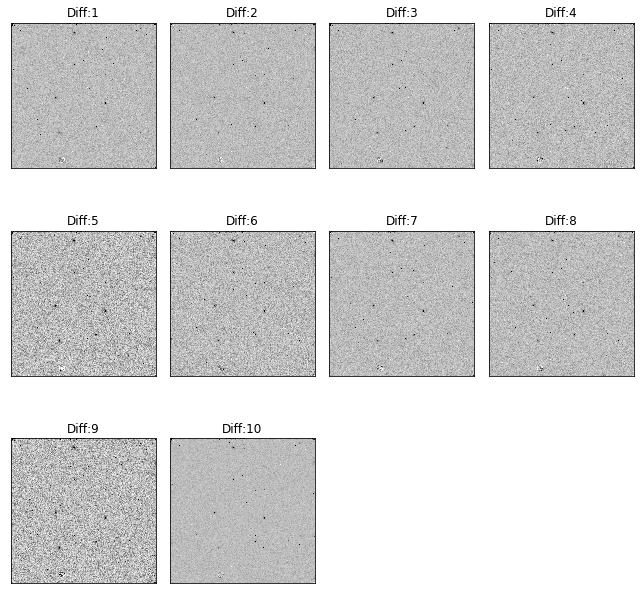

In [13]:
ndiff = len(myDash.diff_files_list)
print('Number of diff files',ndiff)
fig,axarr = plt.subplots((ndiff+3)//4,4, figsize=(9,3*((ndiff+3)//4)))

for i in range(4*((ndiff+3)//4)):

    row = (i)//4
    col = (i)%4
    if (i < ndiff):
        diff_i = fits.open(myDash.diff_files_list[i]+'_diff.fits')
        immed = np.nanmedian(diff_i['SCI'].data)
        stdev = np.nanstd(diff_i['SCI'].data)
        axarr[row,col].imshow(diff_i['SCI'].data,clim=[immed-.3*stdev,immed+.5*stdev],cmap='Greys',origin='lower')
        axarr[row,col].set_title('Diff:'+str(i+1))
        axarr[row,col].set_xticks([]) 
        axarr[row,col].set_yticks([]) 
    else:
        fig.delaxes(axarr[row,col])

fig.tight_layout()

<a id='asn_table'></a>

### 3. Create an association file

This file mimics a typical association file for dithered exposures, that is used by astrodrizzle   
to align and stack multiple exposures taken at the same sky position with small dithers.  
We exploit the fact that a WFC3/IR exposure taken under gyro control can be effectively split into   
individual pseudo-exposures (the diff images).  
Astrodrizzle can treat such pseudo-expsoures as individual dithers, and combine them.

In [14]:
myDash.make_pointing_asn()

#### Show the content of the asn file

In [15]:
asn_filename = 'diff/{}_asn.fits'.format(myDash.root)
asn_table = Table(fits.getdata(asn_filename, ext=1))
asn_table.show_in_notebook()

### 4. Create Segmentation Map

Make segmentation map from original FLT image to assist with background subtraction.  

In [16]:
myDash.create_seg_map()

View segmentation map.

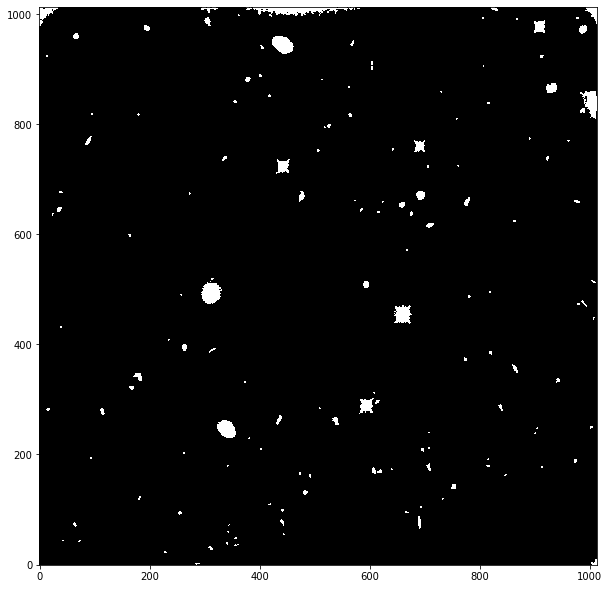

In [17]:
segmap = fits.getdata('icxe01tyq_seg.fits')
fig = plt.figure(figsize=(10, 12.5))
plt.imshow(segmap, origin='lower', vmin=0.6, vmax=0.7, cmap='Greys_r')

<a id='subtract_flt'></a>

<a id='subtract_ext'></a>

### 5. Subtract Background from diff files

Subtract background from the individual reads taken from the original IMA file using the DRZ and SEG imaged produced in the background subtraction of the original FLT.  
By default, this function will subtract the background and write it to the header. Setting parameter subtract to False will not subtract the background and only write it to the header.  
Set parameter reset_stars_dq to True to reset cosmic rays within objects to 0 (because the centers of the stars are flagged).

In [18]:
myDash.subtract_background_reads()

Background subtraction, diff/icxe01tyq_01_diff.fits:  0.6851372718811035
Background subtraction, diff/icxe01tyq_02_diff.fits:  0.6889808773994446
Background subtraction, diff/icxe01tyq_03_diff.fits:  0.710107684135437
Background subtraction, diff/icxe01tyq_04_diff.fits:  0.6938369274139404
Background subtraction, diff/icxe01tyq_05_diff.fits:  0.6984788179397583
Background subtraction, diff/icxe01tyq_06_diff.fits:  0.6817381381988525
Background subtraction, diff/icxe01tyq_07_diff.fits:  0.6816853284835815
Background subtraction, diff/icxe01tyq_08_diff.fits:  0.6878576874732971
Background subtraction, diff/icxe01tyq_09_diff.fits:  0.6920601725578308
Background subtraction, diff/icxe01tyq_10_diff.fits:  0.6799646615982056


<a id='cosmic_rays'></a>

### 6. Fix Cosmic Rays

In [19]:
myDash.fix_cosmic_rays()

Starting 4 L.A.Cosmic iterations
Iteration 1:
0 cosmic pixels this iteration


<a id='align_each_other'></a>

### 7a. Align reads to each other

Align reads to one another by aligning each to the first diff file.  
Uses TweakReg to update the WCS information in the headers of the diff files, then drizzles the images together using Astrodrizzle.  
Refer to documentation to customize parameters for TweakReg and AstroDrizzle.  

Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_01_diff.fits:  -0.14597982168197632
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_02_diff.fits:  -0.14782574772834778
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_03_diff.fits:  -0.14552581310272217
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_04_diff.fits:  -0.14586013555526733
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_05_diff.fits:  -0.1447058916091919
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_06_diff.fits:  -0.14633363485336304
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_07_diff.fits:  -0.14710554480552673


- IDCTAB: Distortion model from row 5 for chip 1 : F160W
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
Retrieving astrometrically-updated WCS "OPUS" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icxe01tyq"
Initializing new WCSCORR table for  /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff.fits
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                

    /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_03_diff.fits
    /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_04_diff.fits
    /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff.fits
    /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff.fits
    /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_07_diff.fits
    /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_08_diff.fits
    /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_09_diff.fits
    /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_10_diff.fits

===  Source finding for image '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_01_diff.fits':
  #  Source finding for '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_01_diff.fits', EXT=('SCI', 1) started at: 13:25:44.021 (24/07/2019)
     Found 74 objects.
===  FINAL number of 

FIT RMSE: 0.025      FIT MAE: 0.02   

RMS_RA: 5.2e-07 (deg)   RMS_DEC: 7.3e-07 (deg)

Final solution based on  24  objects.
wrote XY data to:  icxe01tyq_04_diff_catalog_fit.match
Total # points: 24
# of points after clipping: 24
Total # points: 24
# of points after clipping: 24

Performing fit for: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff.fits

Matching sources from '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff.fits' with sources from reference image '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_01_diff.fits'
Computing initial guess for X and Y shifts...
Found initial X and Y shifts of 0, -0.25 with significance of 13.2 and 16 matches
Found 14 matches for /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff.fits...
Performing "rscale" fit
Computed  rscale  fit for  /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff.fits : 
XSH: 0.0094  YSH: 0.0062   

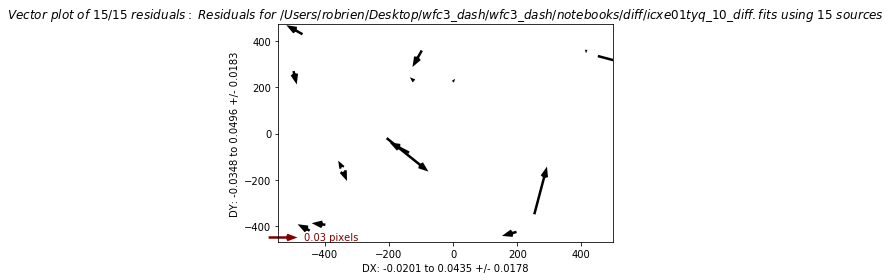

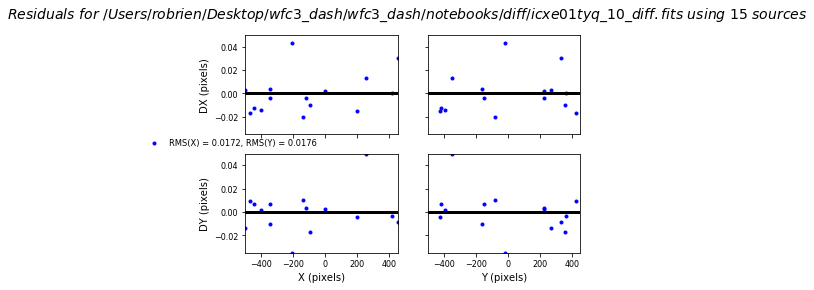

In [20]:
myDash.align(updatehdr=False, updateWCS=False, astrodriz=False)

Print the shifts file to analyze how well the alignment went.  
Do not update header until shifts are satisfactory. 

In [21]:
print(open('shifts_icxe01tyq.txt').read())

# frame: output
# refimage: shifts_icxe01tyq_wcs.fits[wcs]
# form: delta
# units: pixels
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_01_diff.fits    0.000000  0.000000    0.000000     1.000000   0.000000  0.000000
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits    0.003624  -0.000851    0.000877     1.000011   0.028525  0.025532
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_03_diff.fits    0.010291  0.006472    359.999833     1.000009   0.022615  0.021187
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_04_diff.fits    0.002832  0.002491    359.999672     1.000009   0.014710  0.020404
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff.fits    0.009385  0.006175    359.997271     1.000023   0.020567  0.026876
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff.fits    0.009425  -0.001543    359.999324     1.000010   0.016508  0.036679
/Users/

Update header and WCS information, then plot final drizzled image.

Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_01_diff.fits:  -0.14597982168197632


/Users/robrien/Desktop/wfc3_dash/wfc3_dash/reduce_dash.py:503: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (diff[2].data >= data_range[0]) & (diff[2].data <= data_range[1])
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/reduce_dash.py:503: RuntimeWarning: invalid value encountered in less_equal
  mask &= (diff[2].data >= data_range[0]) & (diff[2].data <= data_range[1])


Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_02_diff.fits:  -0.14782574772834778
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_03_diff.fits:  -0.14552581310272217
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_04_diff.fits:  -0.14586013555526733
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_05_diff.fits:  -0.1447058916091919
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_06_diff.fits:  -0.14633363485336304
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_07_diff.fits:  -0.14710554480552673
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_08_diff.fits:  -0.14820599555969238


Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icxe01tyq"
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
Retrieving astrometrically-updated WCS "OPUS" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icxe01tyq"
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
Retrieving astrometrically-updated WCS "OPUS" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icxe01tyq"
- IDCTAB: Distortion model

Performing "rscale" fit
Computed  rscale  fit for  /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits : 
XSH: 0.0036  YSH: -0.0009    ROT: 0.0008768319523    SCALE: 1.000011
FIT XRMS: 0.029      FIT YRMS: 0.026  
FIT RMSE: 0.038      FIT MAE: 0.029  

RMS_RA: 1e-06 (deg)   RMS_DEC: 9.1e-07 (deg)

Final solution based on  17  objects.
wrote XY data to:  icxe01tyq_02_diff_catalog_fit.match
Total # points: 17
# of points after clipping: 17
Total # points: 17
# of points after clipping: 17

....Updating header for /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits...


Processing /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits['SCI',1]

Updating header for /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits[1]
WCS Keywords

CD_11  CD_12: 3.7622219693842775e-05 2.1577279136201817e-07
CD_21  CD_22: 1.1569190884587346e-07 -3.360318283042428e-05
CRVAL    : 150.2285452952561

Computing initial guess for X and Y shifts...
Found initial X and Y shifts of 0.04348, -0.04348 with significance of 20 and 23 matches
Found 21 matches for /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_07_diff.fits...
Performing "rscale" fit
Computed  rscale  fit for  /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_07_diff.fits : 
XSH: 0.0024  YSH: 0.0048    ROT: 359.9992067    SCALE: 1.000009
FIT XRMS: 0.024      FIT YRMS: 0.015  
FIT RMSE: 0.028      FIT MAE: 0.024  

RMS_RA: 8.4e-07 (deg)   RMS_DEC: 5.3e-07 (deg)

Final solution based on  20  objects.
wrote XY data to:  icxe01tyq_07_diff_catalog_fit.match
Total # points: 20
# of points after clipping: 20
Total # points: 20
# of points after clipping: 20

....Updating header for /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_07_diff.fits...


Processing /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_07_diff.fits['SCI',1]

Updating header for /Users/ro



-----  Input file list:  -----

   **  Input image: 'icxe01tyq_01_diff.fits'
       EXT: 'SCI',1;	MASK: icxe01tyq_01_skymatch_mask_sci1.fits[0]

   **  Input image: 'icxe01tyq_02_diff.fits'
       EXT: 'SCI',1;	MASK: icxe01tyq_02_skymatch_mask_sci1.fits[0]

   **  Input image: 'icxe01tyq_03_diff.fits'
       EXT: 'SCI',1;	MASK: icxe01tyq_03_skymatch_mask_sci1.fits[0]

   **  Input image: 'icxe01tyq_04_diff.fits'
       EXT: 'SCI',1;	MASK: icxe01tyq_04_skymatch_mask_sci1.fits[0]

   **  Input image: 'icxe01tyq_05_diff.fits'
       EXT: 'SCI',1;	MASK: icxe01tyq_05_skymatch_mask_sci1.fits[0]

   **  Input image: 'icxe01tyq_06_diff.fits'
       EXT: 'SCI',1;	MASK: icxe01tyq_06_skymatch_mask_sci1.fits[0]

   **  Input image: 'icxe01tyq_07_diff.fits'
       EXT: 'SCI',1;	MASK: icxe01tyq_07_skymatch_mask_sci1.fits[0]

   **  Input image: 'icxe01tyq_08_diff.fits'
       EXT: 'SCI',1;	MASK: icxe01tyq_08_skymatch_mask_sci1.fits[0]

   **  Input image: 'icxe01tyq_09_diff.fits'
       EXT: 'SCI'

Writing out image to disk: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff_single_wht.fits
Writing out image to disk: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_07_diff_single_wht.fits
Writing out image to disk: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_03_diff_single_wht.fits
Writing out image to disk: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_08_diff_single_wht.fits
-Generating simple FITS output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_09_diff_single_sci.fits
-Generating simple FITS output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_10_diff_single_sci.fits
Writing out image to disk: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_09_diff_single_sci.fits
Writing out image to disk: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_10_diff_single_sci.fits
Writing out image to disk: /Users/robr

Creating output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff_sci1_crmask.fits
Removed old cosmic ray mask file: '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff_sci1_crmask.fits'
Creating output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff_sci1_crmask.fits
Removed old cosmic ray mask file: '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_07_diff_sci1_crmask.fits'
Creating output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_07_diff_sci1_crmask.fits
Removed old cosmic ray mask file: '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_08_diff_sci1_crmask.fits'
Creating output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_08_diff_sci1_crmask.fits
Removed old cosmic ray mask file: '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_09_diff_sci1_crmask.fits'
Removed old cosmic ray mask file: '/Users/ro

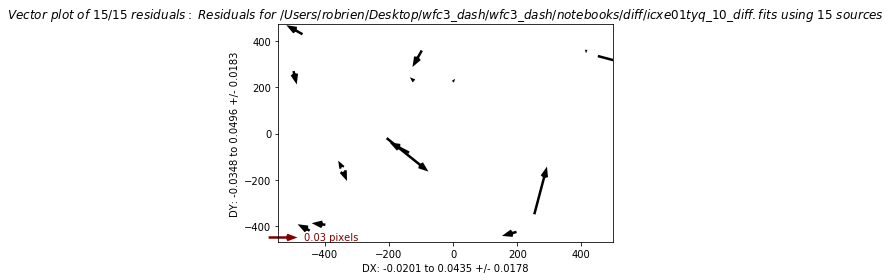

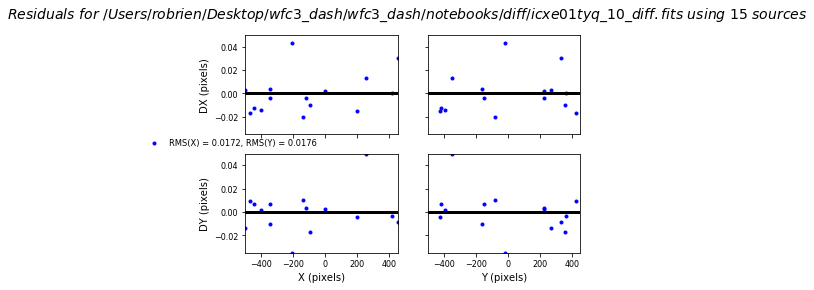

In [22]:
myDash.align()

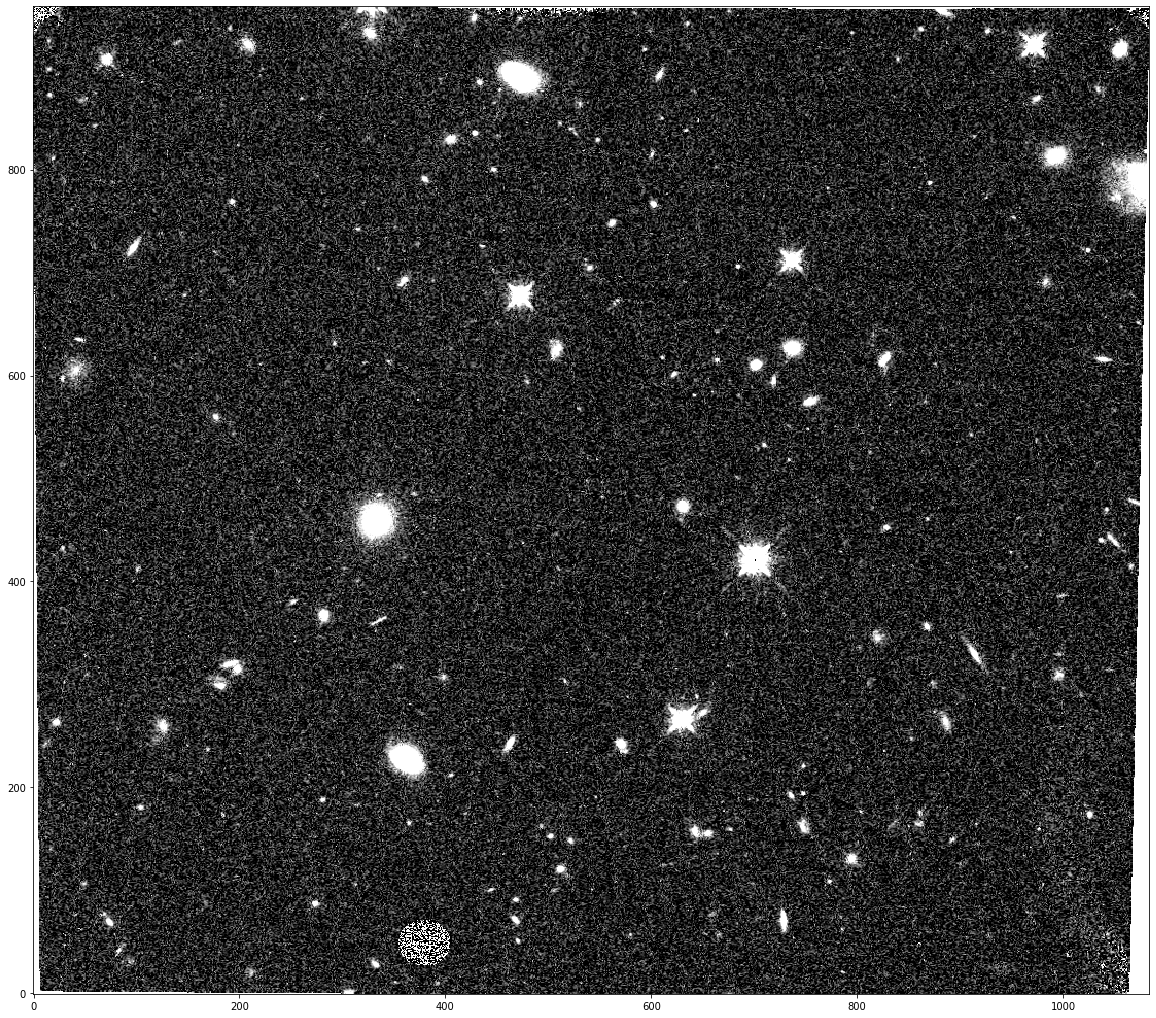

In [23]:
sci = fits.getdata('icxe01tyq_drz_sci.fits')

fig = plt.figure(figsize=(20, 20))

plt.imshow(sci, vmin=-0.05, vmax=0.4, cmap='Greys_r', origin='lower')

<a id='align_cat'></a>

### 7b. Align reads to Gaia<br> 
(procedure taken from https://github.com/spacetelescope/gaia_alignment)

Aligns reads Gaia.

#### Determine coordinates and search area from the WCS's of your images.

Import packages.

In [24]:
import glob
import matplotlib as mpl

from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import wcsaxes
from astropy.coordinates.sky_coordinate import SkyCoord

from astroquery.skyview import SkyView

from matplotlib.patches import Polygon
import matplotlib.cm as cm

%matplotlib inline

Get the WCS information from each input image.

In [25]:
#use coordinates of original exposure
def get_footprints(im_name):
    """Calculates positions of the corners of the science extensions of some image 'im_name' in sky space"""
    footprints = []
    hdu = fits.open(im_name)
    
    flt_flag = 'flt.fits' in im_name or 'flc.fits' in im_name
    
    # Loop ensures that each science extension in a file is accounted for. 
    for ext in hdu:
        if 'SCI' in ext.name:
            hdr = ext.header
            wcs = WCS(hdr, hdu)
            footprint = wcs.calc_footprint(hdr, undistort=flt_flag)
            footprints.append(footprint)
    
    hdu.close()
    return footprints

Record the positions (in RA and DEC) of all the corners of the images in sky space. Take the min, max, and midpoints of each dimensions to determine where and how wide we want to query our coordinates.

In [26]:
def bounds(footprint_list):
    """Calculate RA/Dec bounding box properties from multiple RA/Dec points"""
    
    # flatten list of extensions into numpy array of all corner positions
    merged = [ext for image in footprint_list for ext in image]
    merged = np.vstack(merged)
    ras, decs = merged.T
    
    # Compute width/height
    delta_ra = (max(ras)-min(ras))
    delta_dec = max(decs)-min(decs)

    # Compute midpoints
    ra_midpt = (max(ras)+min(ras))/2.
    dec_midpt = (max(decs)+min(decs))/2.
    

    return ra_midpt, dec_midpt, delta_ra, delta_dec

Determine and save the coordinates.

In [27]:
images = glob.glob('diff/*_diff.fits')
footprint_list = list(map(get_footprints, images))

ra_midpt, dec_midpt, delta_ra, delta_dec = bounds(footprint_list)

coord = SkyCoord(ra=ra_midpt, dec=dec_midpt, unit=u.deg)
print(coord)

<SkyCoord (ICRS): (ra, dec) in deg
    (150.20911987, 1.7800383)>


#### Querying from Gaia

With the coordinates calculated, we now only need to give the search area and perform the query.  Most astroquery supported missions/databases can be passed width/height (for a rectangular search) or a radius (for a circular search).  In either case, these parameters can be passed using astropy.units Quantity 

In [28]:
from astropy.units import Quantity
from astroquery.gaia import Gaia

width = Quantity(delta_ra, u.deg)
height = Quantity(delta_dec, u.deg)

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


Perfom the query.

In [29]:
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)

Query finished.


#### Aligning Data to Catalog

In [30]:
from astropy.table import Table

ras = r['ra']
decs = r['dec']
mags = r['phot_g_mean_mag']
ra_error = r['ra_error']
dec_error = r['dec_error']

tbl = Table([ras, decs]) # Make a temporary table of just the positions
tbl.write('gaia.cat', format='ascii.fast_commented_header') # Save the table to a file.  The format argument ensures
                                                            # the first line will be commented out.

In [31]:
thresh = 10.

def get_error_mask(catalog, max_error):
    """Returns a mask for rows in catalog where RA and Dec error are less than max_error"""
    ra_mask = catalog['ra_error']< max_error
    dec_mask = catalog['dec_error'] < max_error
    mask = ra_mask & dec_mask
#     print('Cutting sources with error higher than {}'.format(max_error))
#     print('Number of sources befor filtering: {}\nAfter filtering: {}\n'.format(len(mask),sum(mask)))
    return mask

mask = get_error_mask(r, thresh)

tbl_filtered = Table([ras[mask], decs[mask]]) 
tbl.write('gaia_filtered_{}_mas.cat'.format(thresh), format='ascii.fast_commented_header')

#### Align images. <br>
Parameters ref_catalog and ref_image denote the reference catalog and reference image, respectively.  
Note: Must be connected to STScI network in order to align to Gaia (specifically to use updatewcs function on the input images for TweakReg). To not use this function, set parameter updatewcsfn to False.

If an error arises, try lowering the threshold.

Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_01_diff.fits:  -0.1460149884223938


/Users/robrien/Desktop/wfc3_dash/wfc3_dash/reduce_dash.py:503: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (diff[2].data >= data_range[0]) & (diff[2].data <= data_range[1])
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/reduce_dash.py:503: RuntimeWarning: invalid value encountered in less_equal
  mask &= (diff[2].data >= data_range[0]) & (diff[2].data <= data_range[1])


Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_02_diff.fits:  -0.1478281021118164
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_03_diff.fits:  -0.1455266773700714
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_04_diff.fits:  -0.14588576555252075
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_05_diff.fits:  -0.1447138786315918
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_06_diff.fits:  -0.14633363485336304
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_07_diff.fits:  -0.14714568853378296
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_08_diff.fits:  -0.14820891618728638
Ke


===  Source finding for image '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_04_diff.fits':
  #  Source finding for '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_04_diff.fits', EXT=('SCI', 1) started at: 13:27:08.938 (24/07/2019)
     Found 259 objects.
===  FINAL number of objects in image '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_04_diff.fits': 259

===  Source finding for image '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff.fits':
  #  Source finding for '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff.fits', EXT=('SCI', 1) started at: 13:27:09.200 (24/07/2019)
     Found 137 objects.
===  FINAL number of objects in image '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff.fits': 137

===  Source finding for image '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff.fits':
  #  Source finding for '/Users/r

Performing fit for: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff.fits

Matching sources from '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff.fits' with sources from reference catalog 'gaia.cat'
Computing initial guess for X and Y shifts...
Found initial X and Y shifts of -5, -3 with significance of 6 and 6 matches
Found 6 matches for /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff.fits...
Performing "rscale" fit
Computed  rscale  fit for  /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff.fits : 
XSH: -4.9074  YSH: -2.8020    ROT: 0.02437114803    SCALE: 1.000139
FIT XRMS: 0.097      FIT YRMS: 0.18   
FIT RMSE: 0.2        FIT MAE: 0.17   

RMS_RA: 3.4e-06 (deg)   RMS_DEC: 6.4e-06 (deg)

Final solution based on  6  objects.
wrote XY data to:  icxe01tyq_06_diff_catalog_fit.match
Total # points: 6
# of points after clipping: 6
Total # points: 6
# of points after clipping: 6

Pe

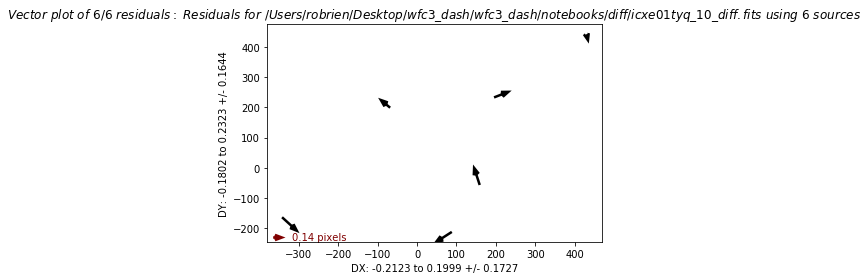

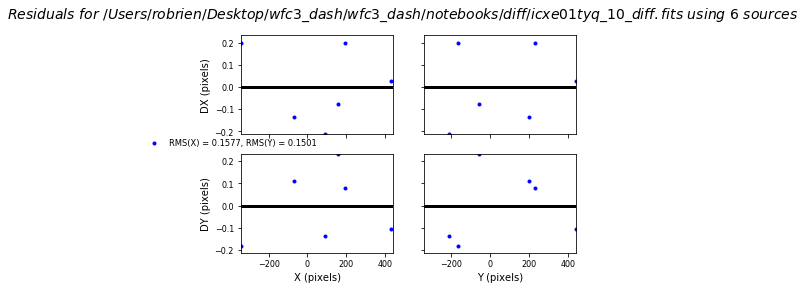

In [32]:
myDash.align(align_method='CATALOG', ref_catalog='gaia.cat', 
             wcsname='GAIA', threshold=10., searchrad=1000., cw=5., updatehdr=False, updateWCS=False, astrodriz=False)

Inspect the shifts file to see if method used produced sufficient results. Notice that some diff files could not sufficiently line up with Gaia. It is up to the user to determine whether this is sufficient or not.

In [33]:
print(open('shifts_icxe01tyq.txt').read())

# frame: output
# refimage: shifts_icxe01tyq_wcs.fits[wcs]
# form: delta
# units: pixels
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_01_diff.fits    nan  nan    nan     nan   0.000000  0.000000
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits    nan  nan    nan     nan   0.000000  0.000000
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_03_diff.fits    nan  nan    nan     nan   0.000000  0.000000
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_04_diff.fits    -4.786391  -2.843955    0.016320     1.000229   0.092012  0.057045
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff.fits    -4.841190  -2.774923    0.018568     1.000094   0.100258  0.148828
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff.fits    -4.907373  -2.802034    0.024371     1.000139   0.096518  0.179615
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_07_

Update header and plot aligned science images.

Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_01_diff.fits:  -0.1460149884223938


/Users/robrien/Desktop/wfc3_dash/wfc3_dash/reduce_dash.py:503: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (diff[2].data >= data_range[0]) & (diff[2].data <= data_range[1])
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/reduce_dash.py:503: RuntimeWarning: invalid value encountered in less_equal
  mask &= (diff[2].data >= data_range[0]) & (diff[2].data <= data_range[1])


Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_02_diff.fits:  -0.1478281021118164
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_03_diff.fits:  -0.1455266773700714
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_04_diff.fits:  -0.14588576555252075
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_05_diff.fits:  -0.1447138786315918
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_06_diff.fits:  -0.14633363485336304
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_07_diff.fits:  -0.14714568853378296
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_08_diff.fits:  -0.14820891618728638
Ke

Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icxe01tyq"
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
Retrieving astrometrically-updated WCS "OPUS" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icxe01tyq"
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
Retrieving astrometrically-updated WCS "OPUS" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icxe01tyq"
- IDCTAB: Distortion model

# WARNING:                                                                   #
# Not enough matches (< 5) found for input image: /Users/robrien/Desktop/wfc #
# 3_dash/wfc3_dash/notebooks/diff/icxe01tyq_01_diff.fits                     #
#                                                                            #
##############################################################################

Performing fit for: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits

Matching sources from '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits' with sources from reference catalog 'gaia.cat'
Computing initial guess for X and Y shifts...
Found initial X and Y shifts of -5, -3 with significance of 4 and 4 matches
##############################################################################
#                                                                            #
# WARNING:                                                            

FIT XRMS: 0.14       FIT YRMS: 0.17   
FIT RMSE: 0.22       FIT MAE: 0.21   

RMS_RA: 5e-06 (deg)   RMS_DEC: 6.2e-06 (deg)

Final solution based on  6  objects.
wrote XY data to:  icxe01tyq_08_diff_catalog_fit.match
Total # points: 6
# of points after clipping: 6
Total # points: 6
# of points after clipping: 6

....Updating header for /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_08_diff.fits...


Processing /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_08_diff.fits['SCI',1]

Updating header for /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_08_diff.fits[1]
WCS Keywords

CD_11  CD_12: 3.7624091343986477e-05 1.9804194275777772e-07
CD_21  CD_22: 9.583436041337777e-08 -3.360491390389202e-05
CRVAL    : 150.2287231814018 1.7129662077308077
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13544214734974191
ORIENTAT : 179.66234592475044
WCSNAME  :  GAIA

Performing fit for: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/n


   *   Image: icxe01tyq_07_diff.fits
       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504

   *   Image: icxe01tyq_08_diff.fits
       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504

   *   Image: icxe01tyq_09_diff.fits
       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504

   *   Image: icxe01tyq_10_diff.fits
       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'icxe01tyq_01_diff.fits['SCI',1]'  --  SKY = -1.2197597204955786 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.0200627   NEW MDRIZSKY = -0.0200627
   *   Image:   'icx

reference sky value for image '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_09_diff.fits' is -0.4883882658123968
reference sky value for image '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_10_diff.fits' is -0.5005806494975094
Saving output median image to: 'icxe01tyq_med.fits'
==== Processing Step  Create Median  finished at  13:27:57.22 (24/07/2019)

==== Processing Step  Blot  started at  13:27:57.231 (24/07/2019)
    Blot: creating blotted image:  /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_01_diff.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_01_diff_sci1_blt.fits
Writing out image to disk: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_01_diff_sci1_blt.fits
    Blot: creating blotted image:  /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits[sci,1

          Create Median          1.4706 sec.
                   Blot          4.6797 sec.
                Driz_CR          2.3554 sec.
          Final Drizzle          5.9827 sec.
   ====================          ====================
                  Total          20.4197 sec.
Trailer file written to:  astrodrizzle.log


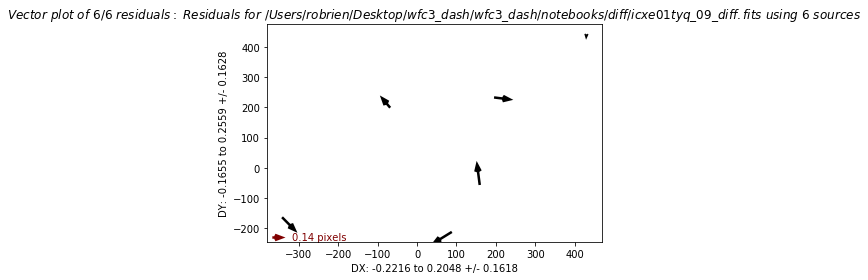

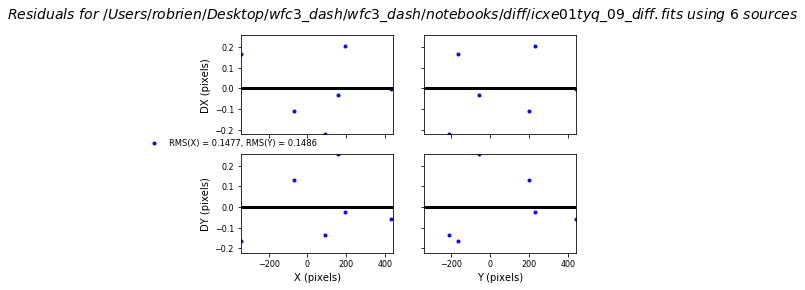

In [34]:
myDash.align(align_method='CATALOG', ref_catalog='gaia.cat', 
             wcsname='GAIA', threshold=100., searchrad=1000., cw=5.)

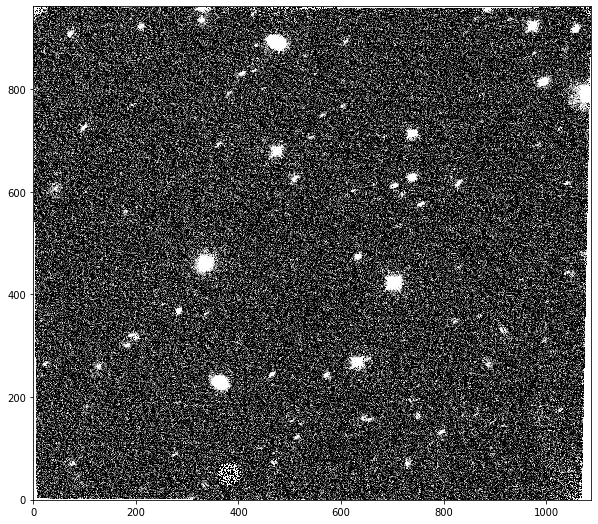

In [35]:
sci = fits.getdata('icxe01tyq_drz_sci.fits')

fig = plt.figure(figsize=(10, 10))

plt.imshow(sci, vmin=-0.05, vmax=0.4, cmap='Greys_r', origin='lower')

<a id='align_both'></a>

### 7c. Align reads to each other, then align final read to Gaia

Will most likely give better results, especially if not enough sources are found using catalog method alone.

Align sources to each other using TweakReg.

/Users/robrien/Desktop/wfc3_dash/wfc3_dash/reduce_dash.py:503: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (diff[2].data >= data_range[0]) & (diff[2].data <= data_range[1])
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/reduce_dash.py:503: RuntimeWarning: invalid value encountered in less_equal
  mask &= (diff[2].data >= data_range[0]) & (diff[2].data <= data_range[1])


Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_01_diff.fits:  -0.1460149884223938
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_02_diff.fits:  -0.1478281021118164
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_03_diff.fits:  -0.1455266773700714
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_04_diff.fits:  -0.14588767290115356
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_05_diff.fits:  -0.1447163224220276
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_06_diff.fits:  -0.14633363485336304
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_07_diff.fits:  -0.14715027809143066
Key

Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icxe01tyq"
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
Retrieving astrometrically-updated WCS "OPUS" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icxe01tyq"
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
Retrieving astrometrically-updated WCS "OPUS" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icxe01tyq"
Retrieving astrometrically-update

Computing initial guess for X and Y shifts...
Found initial X and Y shifts of -0.1818, 0 with significance of 9 and 11 matches
Found 9 matches for /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits...
Performing "rscale" fit
Computed  rscale  fit for  /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits : 
XSH: -0.0085  YSH: -0.0055    ROT: 0.001838400991    SCALE: 1.000014
FIT XRMS: 0.025      FIT YRMS: 0.02   
FIT RMSE: 0.032      FIT MAE: 0.025  

RMS_RA: 9.1e-07 (deg)   RMS_DEC: 7.1e-07 (deg)

Final solution based on  9  objects.
wrote XY data to:  icxe01tyq_02_diff_catalog_fit.match
Total # points: 9
# of points after clipping: 9
Total # points: 9
# of points after clipping: 9

....Updating header for /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits...


Processing /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits['SCI',1]

Updating header for /Users/robrien/Des

WCSNAME  :  DASH

Performing fit for: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_07_diff.fits

Matching sources from '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_07_diff.fits' with sources from reference image '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_01_diff.fits'
Computing initial guess for X and Y shifts...
Found initial X and Y shifts of 0.06667, -0.06667 with significance of 12 and 15 matches
Found 13 matches for /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_07_diff.fits...
Performing "rscale" fit
Computed  rscale  fit for  /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_07_diff.fits : 
XSH: -0.0062  YSH: 0.0019    ROT: 359.9993541    SCALE: 1.000004
FIT XRMS: 0.013      FIT YRMS: 0.011  
FIT RMSE: 0.017      FIT MAE: 0.013  

RMS_RA: 4.8e-07 (deg)   RMS_DEC: 3.7e-07 (deg)

Final solution based on  12  objects.
wrote XY data to:  icxe01tyq_07_diff_catalog_fit.match

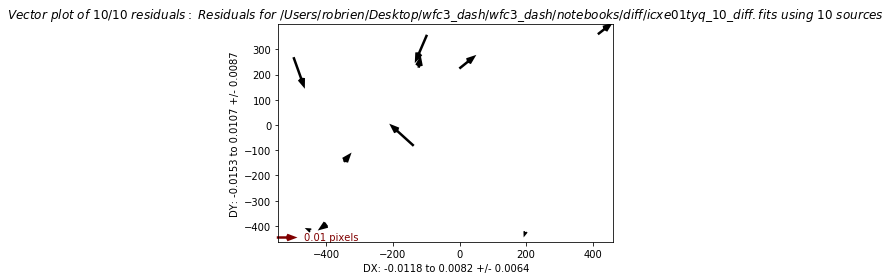

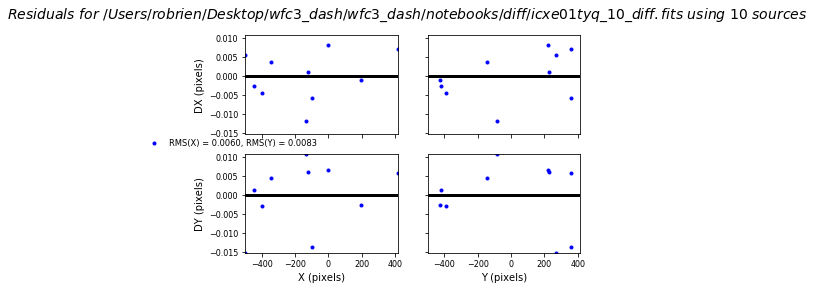

In [36]:
myDash.align(astrodriz=False)

Align updated images to Gaia.

In [37]:
myDash.align(align_method='CATALOG', ref_catalog='gaia.cat', wcsname='GAIA',
             threshold=2., searchrad=1000., cw=5.)

/Users/robrien/Desktop/wfc3_dash/wfc3_dash/reduce_dash.py:503: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (diff[2].data >= data_range[0]) & (diff[2].data <= data_range[1])
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/reduce_dash.py:503: RuntimeWarning: invalid value encountered in less_equal
  mask &= (diff[2].data >= data_range[0]) & (diff[2].data <= data_range[1])


Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_01_diff.fits:  -0.1460149884223938
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_02_diff.fits:  -0.1478281021118164
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_03_diff.fits:  -0.1455266773700714
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_04_diff.fits:  -0.14588767290115356
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_05_diff.fits:  -0.1447163224220276
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_06_diff.fits:  -0.14633363485336304
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/icxe01tyq_07_diff.fits:  -0.14715027809143066
Key

Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icxe01tyq"
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
Retrieving astrometrically-updated WCS "OPUS" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icxe01tyq"
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
Retrieving astrometrically-updated WCS "OPUS" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icxe01tyq"
Retrieving astrometrically-update

Computing initial guess for X and Y shifts...
Found initial X and Y shifts of -363.4, -214.1 with significance of 3.919 and 7 matches
##############################################################################
#                                                                            #
# WARNING:                                                                   #
# Not enough matches (< 5) found for input image: /Users/robrien/Desktop/wfc #
# 3_dash/wfc3_dash/notebooks/diff/icxe01tyq_01_diff.fits                     #
#                                                                            #
##############################################################################

Performing fit for: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits

Matching sources from '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits' with sources from reference catalog 'gaia.cat'
Computing initial guess for X and Y shifts...
Found initia

#                                                                            #
##############################################################################

Performing fit for: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_10_diff.fits

Matching sources from '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_10_diff.fits' with sources from reference catalog 'gaia.cat'
Computing initial guess for X and Y shifts...
Found initial X and Y shifts of 726.2, -503.6 with significance of 3.922 and 5 matches
##############################################################################
#                                                                            #
# WARNING:                                                                   #
# Not enough matches (< 5) found for input image: /Users/robrien/Desktop/wfc #
# 3_dash/wfc3_dash/notebooks/diff/icxe01tyq_10_diff.fits                     #
#                                                          

       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.0206167   NEW MDRIZSKY = -0.0206167
   *   Image:   'icxe01tyq_08_diff.fits['SCI',1]'  --  SKY = -1.1984191074342276 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.0197117   NEW MDRIZSKY = -0.0197117
   *   Image:   'icxe01tyq_09_diff.fits['SCI',1]'  --  SKY = -1.187685384240524 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.0195351   NEW MDRIZSKY = -0.0195351
   *   Image:   'icxe01tyq_10_diff.fits['SCI',1]'  --  SKY = -1.2173353920632397 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.0200228   NEW MDRIZSKY = -0.0200228
***** skymatch ended on 2019-07-24 13:29:31.017206
TOTAL RUN TIME: 0:00:00.782165
==== Processing Step  Subtract Sky  finished at  13:29:31.273 (24/07/2019)

==== Processing Step  Separate Drizzle  started at  13:29:31.275 (24/07/2019)
WCS Keywords


    Blot: creating blotted image:  /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff_sci1_blt.fits
Writing out image to disk: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff_sci1_blt.fits
    Blot: creating blotted image:  /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff_sci1_blt.fits
Writing out image to disk: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff_sci1_blt.fits
    Blot: creating blotted image:  /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_07_diff.fits[sci,1]
Using default C-based coordinate transformation...


Inspect the shifts file to see if method used produced sufficient results. Then plot final drizzled image.

In [38]:
print(open('shifts_icxe01tyq.txt').read())

# frame: output
# refimage: shifts_icxe01tyq_wcs.fits[wcs]
# form: delta
# units: pixels
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_01_diff.fits    nan  nan    nan     nan   0.000000  0.000000
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits    nan  nan    nan     nan   0.000000  0.000000
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_03_diff.fits    nan  nan    nan     nan   0.000000  0.000000
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_04_diff.fits    nan  nan    nan     nan   0.000000  0.000000
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff.fits    nan  nan    nan     nan   0.000000  0.000000
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff.fits    nan  nan    nan     nan   0.000000  0.000000
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_07_diff.fits    nan  nan    nan     nan   0.000000  0.000000
/Users/r

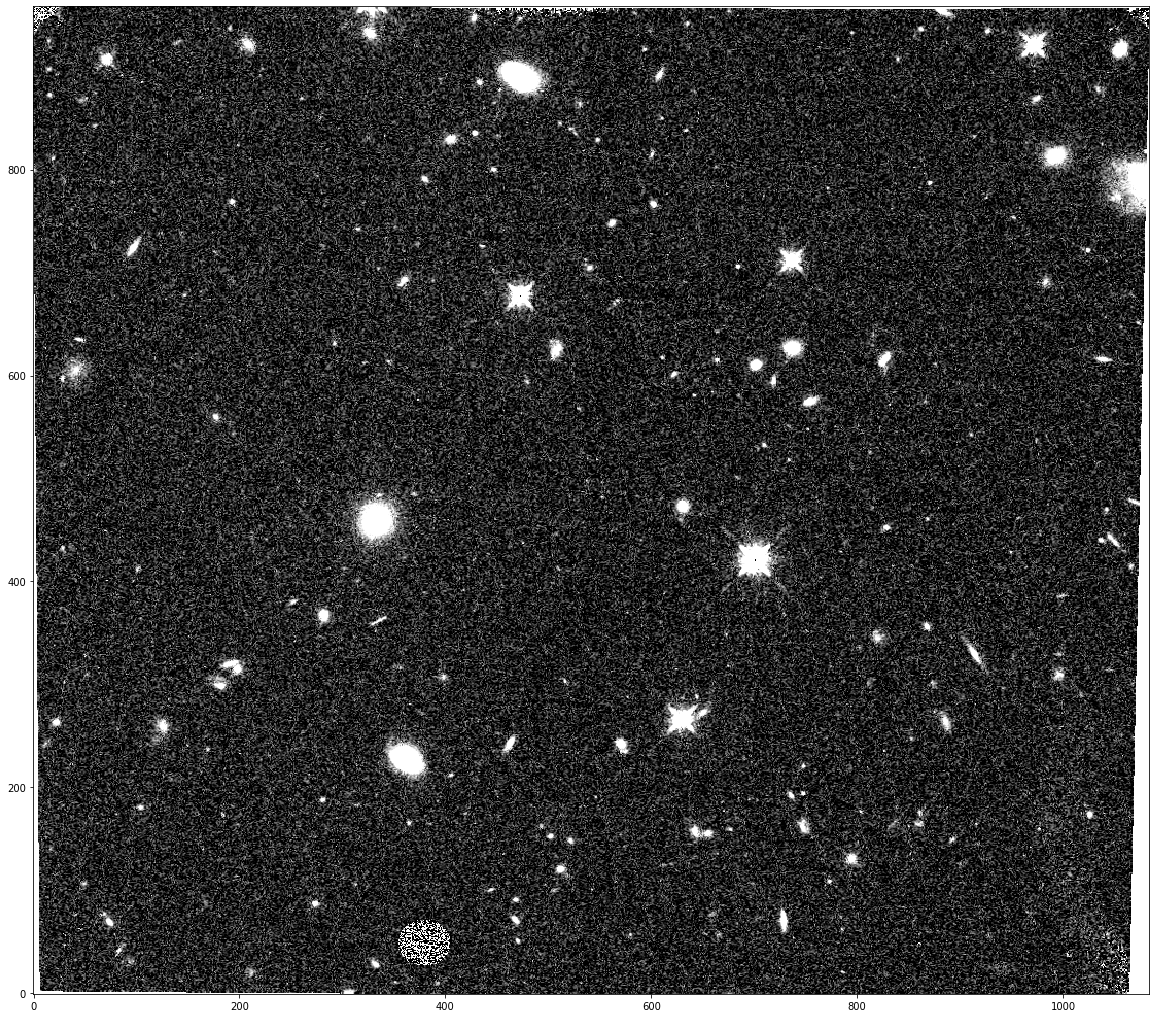

In [39]:
sci = fits.getdata('icxe01tyq_drz_sci.fits')

fig = plt.figure(figsize=(20, 20))

plt.imshow(sci, vmin=-0.05, vmax=0.4, cmap='Greys_r', origin='lower')

<a id='mosaic'></a>

## Using main function to create mosaic

Creates mosaic from multiple exposures using DashData class.

In [41]:
#main()